In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid 
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split 
from torchvision import transforms 
from torchvision.utils import save_image 
from datetime import datetime
%matplotlib inline 

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
torch.manual_seed(43)

train_ds = CIFAR10("data/", train=True, download=True, transform=transform_train)
val_size = 10000 
train_size = len(train_ds) - val_size 
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) 

test_ds = CIFAR10("data/", train=False, download=True, transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [4]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False) 
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False) 


In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AlexNet().to(device) 

learning_rate = 1e-4 
load_model = True 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

N_EPOCHS = 50 

In [7]:
train_loss = [] 
val_accuracy = []

for epoch in range(50):
    loss_ep = 0 

    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device) 
        targets = targets.to(device=device)

        # Forward Pass 
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")
    train_loss.append(loss_ep / len(train_dl)) 
    
    with torch.no_grad(): 
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            # Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
            val_accuracy.append(num_correct / num_samples)
        
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

Loss in epoch 0 :::: 1.507936727142334
Got 5793 / 10000 with accuracy 57.93
Loss in epoch 1 :::: 0.9972855783462524
Got 6732 / 10000 with accuracy 67.32
Loss in epoch 2 :::: 0.7642265497684478
Got 7401 / 10000 with accuracy 74.01
Loss in epoch 3 :::: 0.6158788241863251
Got 7542 / 10000 with accuracy 75.42
Loss in epoch 4 :::: 0.5135951350212097
Got 7881 / 10000 with accuracy 78.81
Loss in epoch 5 :::: 0.417810942530632
Got 8018 / 10000 with accuracy 80.18
Loss in epoch 6 :::: 0.33497451033592224
Got 8064 / 10000 with accuracy 80.64
Loss in epoch 7 :::: 0.26818108838796617
Got 8042 / 10000 with accuracy 80.42
Loss in epoch 8 :::: 0.21283530923128127
Got 8145 / 10000 with accuracy 81.45
Loss in epoch 9 :::: 0.17060982523560525
Got 8209 / 10000 with accuracy 82.09
Loss in epoch 10 :::: 0.13830615979433059
Got 8246 / 10000 with accuracy 82.46
Loss in epoch 11 :::: 0.12187085514813661
Got 8015 / 10000 with accuracy 80.15
Loss in epoch 12 :::: 0.10582849079295993
Got 8231 / 10000 with accura

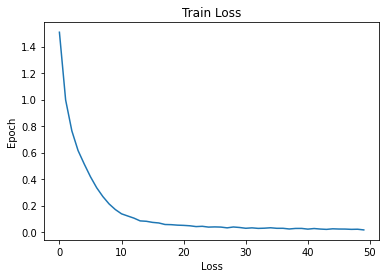

In [10]:
plt.title("Train Loss")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.plot(train_loss)
plt.show()

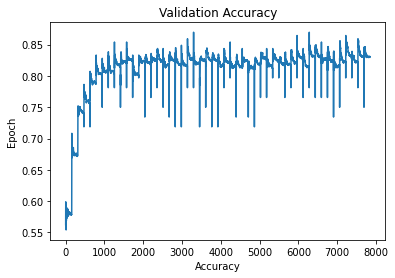

In [17]:
plt.title("Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.plot([t.cpu().data.numpy() for t in val_accuracy])
plt.show()

In [23]:
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_dl):
    data = data.to(device="cpu")
    targets = targets.to(device="cpu")
    # Forward Pass
    scores = model(data.to(device="cuda")).to(device="cpu")
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)

print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}")

Accuracy 83.01
